In [21]:
from datetime import datetime
from finance_utils.backtest import Backtest
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [99]:
universe = pd.read_csv('/Users/henrywzh/Documents/data/us_big.csv')
universe.set_index('Date', inplace=True)
universe.index = pd.to_datetime(universe.index)

In [100]:
rand_factor = np.random.normal(size=len(universe))

In [101]:
u_2010 = universe[universe.index >= '2010-01-01']

In [137]:
days_ahead = 42
def test_factor(x: pd.Series, fast: int, slow: int, holding_period: int):
    # x is the price
    ma_fast = x.rolling(fast).mean()
    ma_slow = x.rolling(slow).mean()
    _ratio = ((ma_fast - ma_slow) / ma_slow).dropna()

    if _ratio.shape[0] == 0: return None, None
    
    _x = x[x.index >= _ratio.index[0]]
    _rolling_rets = _x.shift(-holding_period) / _x - 1
    _rolling_rets = _rolling_rets[_rolling_rets.index >= _ratio.index[0]].dropna()
    
    if _rolling_rets.shape[0] == 0: return None, None
    _ratio = _ratio[_ratio.index <= _rolling_rets.index[-1]]
    
    return _ratio, _rolling_rets

In [138]:
x = u_2010['AAPL']
rets = x.pct_change()
ratio = ((x.rolling(42).mean() - x.rolling(120).mean()) / x.rolling(120).mean()).dropna()
x = x[x.index >= ratio.index[0]]
rets = rets[rets.index >= ratio.index[0]]

rolling_rets = x.shift(-days_ahead) / x - 1
rolling_rets = rolling_rets[rolling_rets.index >= ratio.index[0]]

<Axes: xlabel='Date'>

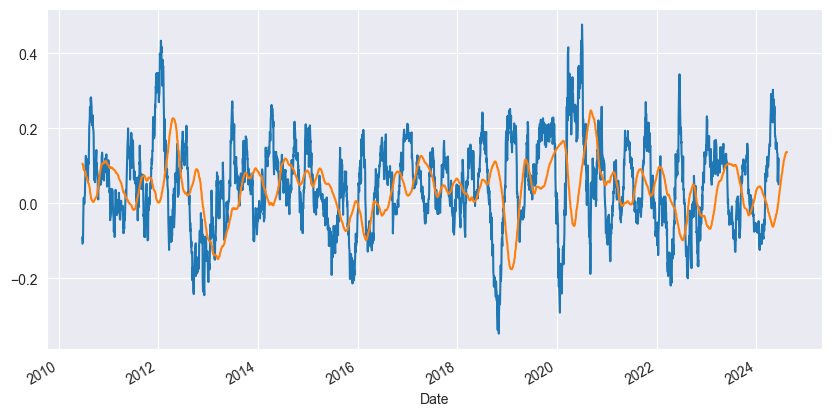

In [139]:
plt.figure(figsize=(10, 5))

rolling_rets.plot()
ratio.plot()

ratio = fast / slow - 1
- ratio > 0: recent prices are above the historic average

In [157]:
# -- Ranking --
fast = 42
slow = 250
holding_period = 21

datas = []

for i in range(10):
    returns = []
    vals = []
    stocks = []
    
    for col in u_2010.columns:
        ts_factor, ts_future_rets = test_factor(u_2010[col], fast, slow, holding_period)
        if ts_factor is None:
            continue
        
        returns.append(ts_future_rets.iloc[-(1 + i * 5)])
        vals.append(ts_factor.iloc[-(1 + i * 5)])
        stocks.append(col)
        
    data = pd.DataFrame({'Future Return': returns, 'Factor Value': vals}, index=stocks)
    datas.append(data)

In [158]:
def ranking(_data):
    # Rank the equities
    ranked_data = _data.sort_values(by=['Factor Value'])
    
    # Compute the returns of each basket
    # Baskets of size 500, so we create an empty array of shape (10000/500)
    number_of_baskets = 20
    basket_returns = np.zeros(number_of_baskets)
    
    for i in range(number_of_baskets):
        start = i * 20
        end = i * 20 + 20 
        basket_returns[i] = ranked_data[start:end]['Future Return'].mean()
    
    # Plot the returns of each basket
    plt.bar(range(number_of_baskets), basket_returns)
    plt.ylabel('Returns')
    plt.xlabel('Basket')
    plt.legend(['Returns of Each Basket'])

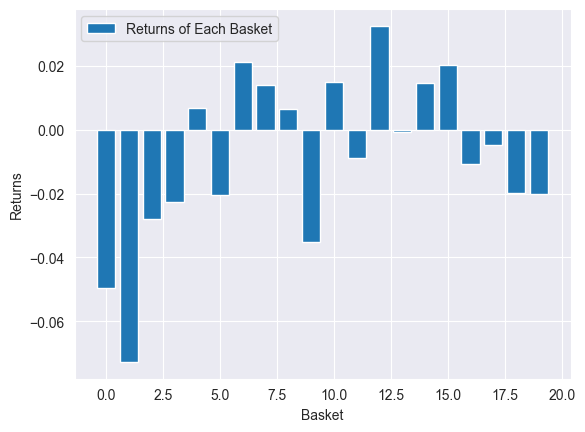

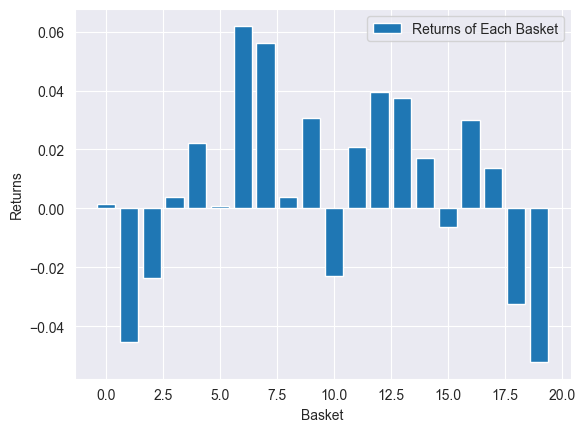

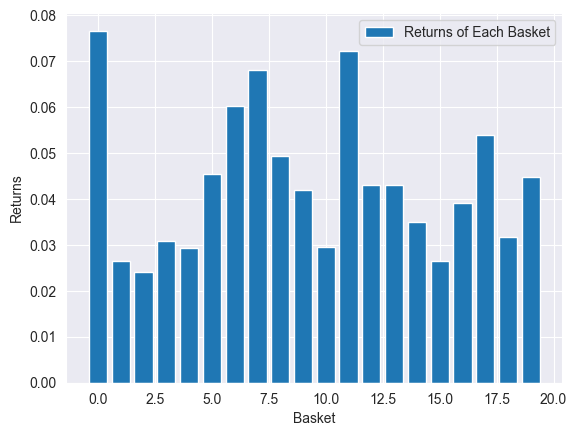

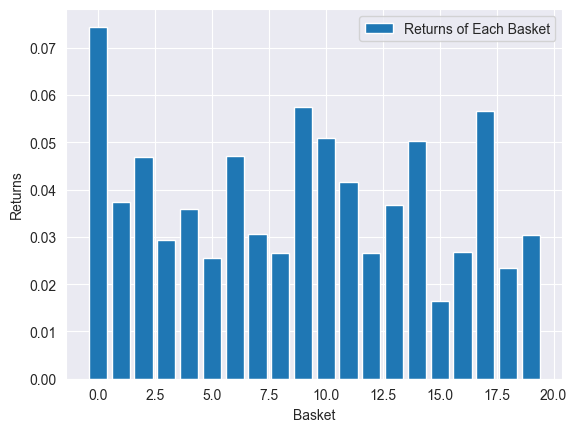

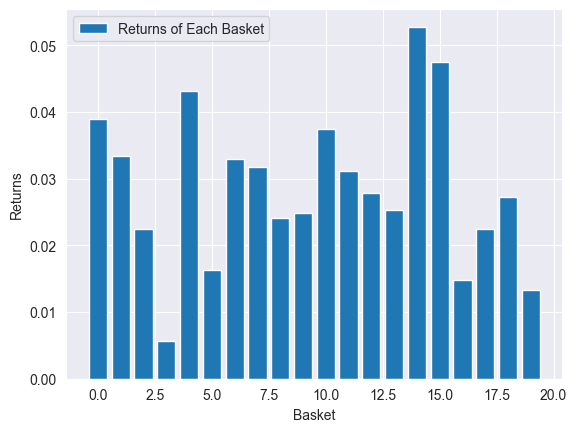

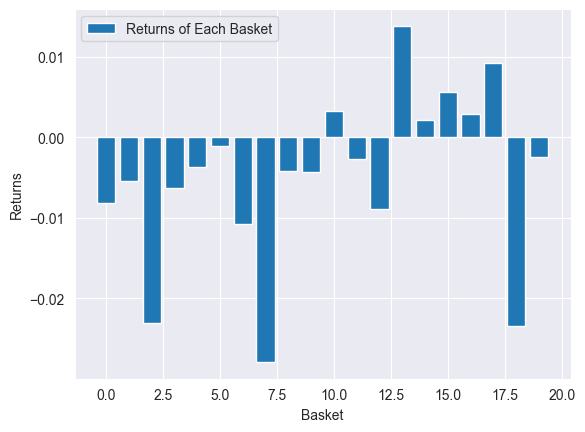

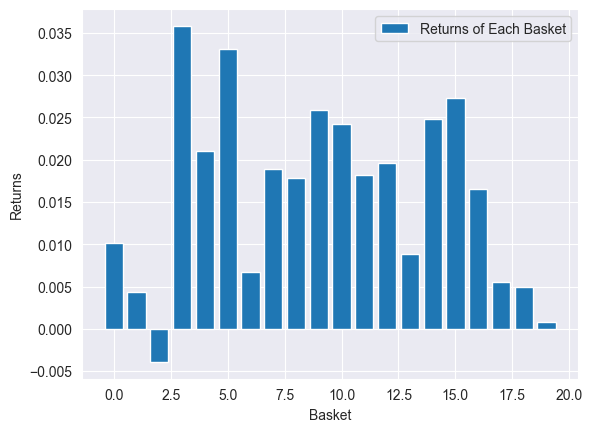

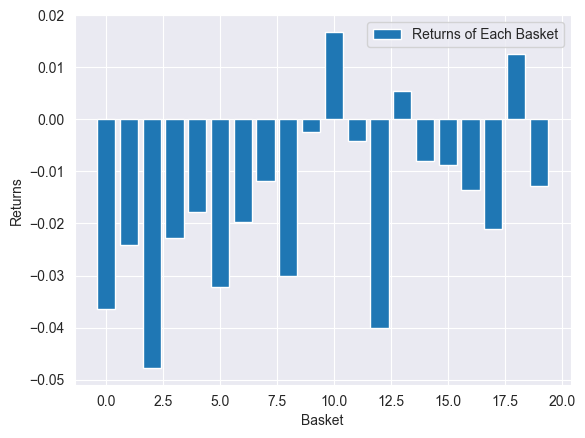

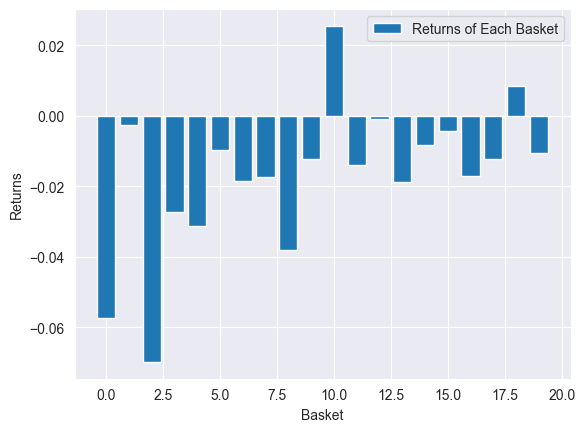

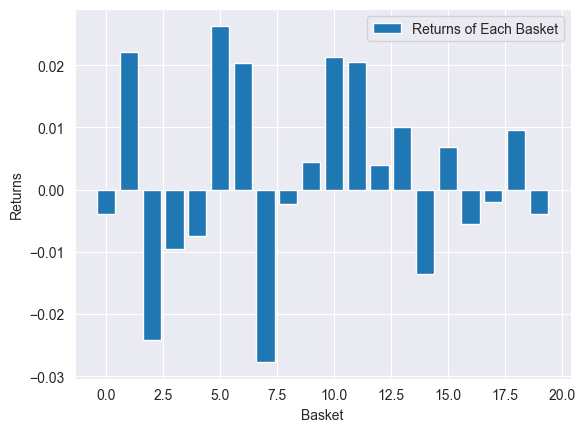

In [161]:
for d in datas:
    ranking(d)
    plt.show()